In [1]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df = df.sample(frac=1, random_state=0)
df.head()

,Text,Sentiment
11841,Al Pacino was once an actor capable of making ...,0
19602,After Chaplin made one of his best films: Doug...,0
45519,This movie is sort of a Carrie meets Heavy Met...,1
25747,I have fond memories of watching this visually...,1
42642,"In the '70s, Charlton Heston starred in sci-fi...",1


In [2]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  In Theodore Rex poor Whoopi Goldberg is set up...   
1          24884  24884  The rating is only a 5 because it's a movie th...   

                
          freq  
Sentiment       
0            1  
1            1

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
x = df.apply(lambda row: remove_stop_words(row['Text']), axis=1)
y = df['Sentiment']

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding

model = Sequential() 
model.add(Embedding(max_words, 16, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 8000)              0         
                                                                 
 dense (Dense)               (None, 128)               1024128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,184,257
Trainable params: 1,184,257
Non-trainable params: 0
_________________________________________________________________


In [6]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)

Epoch 1/5
159/159 [==============================] - 2s 13ms/step - loss: 0.5484 - accuracy: 0.6896 - val_loss: 0.2780 - val_accuracy: 0.8853
Epoch 2/5
159/159 [==============================] - 2s 12ms/step - loss: 0.2272 - accuracy: 0.9100 - val_loss: 0.2618 - val_accuracy: 0.8935
Epoch 3/5
159/159 [==============================] - 2s 12ms/step - loss: 0.1372 - accuracy: 0.9523 - val_loss: 0.2947 - val_accuracy: 0.8845
Epoch 4/5
159/159 [==============================] - 2s 12ms/step - loss: 0.0592 - accuracy: 0.9834 - val_loss: 0.3804 - val_accuracy: 0.8806
Epoch 5/5
159/159 [==============================] - 2s 12ms/step - loss: 0.0180 - accuracy: 0.9973 - val_loss: 0.4614 - val_accuracy: 0.8808


[]

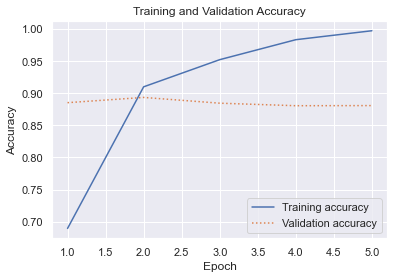

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [8]:
cleaned_text = remove_stop_words('Excellent food and fantastic service!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.9650818

In [9]:
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.029477209

## Conv1D

In [10]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
 
model = Sequential()
model.add(Embedding(max_words, 16, input_length=max_length))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

Model: "sequential_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 embedding_1 (Embedding)                     (None, 500, 16)                         160000         
                                                                                                    
 conv1d (Conv1D)                             (None, 496, 32)                         2592           
                                                                                                    
 max_pooling1d (MaxPooling1D)                (None, 99, 32)                          0              
                                                                                                    
 conv1d_1 (Conv1D)                           (None, 95, 32)                          5152           
                                                                     

In [11]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)

Epoch 1/5
159/159 [==============================] - 6s 36ms/step - loss: 0.4991 - accuracy: 0.7272 - val_loss: 0.3002 - val_accuracy: 0.8740
Epoch 2/5
159/159 [==============================] - 6s 35ms/step - loss: 0.2446 - accuracy: 0.9032 - val_loss: 0.2889 - val_accuracy: 0.8787
Epoch 3/5
159/159 [==============================] - 6s 35ms/step - loss: 0.1820 - accuracy: 0.9330 - val_loss: 0.3204 - val_accuracy: 0.8765
Epoch 4/5
159/159 [==============================] - 6s 35ms/step - loss: 0.1374 - accuracy: 0.9530 - val_loss: 0.3446 - val_accuracy: 0.8767
Epoch 5/5
159/159 [==============================] - 6s 35ms/step - loss: 0.0888 - accuracy: 0.9731 - val_loss: 0.4194 - val_accuracy: 0.8697


[]

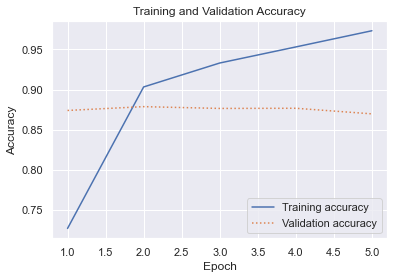

In [12]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [13]:
cleaned_text = remove_stop_words('Excellent food and fantastic service!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.9808183

In [14]:
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.40665454

## LSTM

In [20]:
from tensorflow.keras.layers import LSTM, Bidirectional
 
model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(16, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

Model: "sequential_3"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 embedding_3 (Embedding)                     (None, 500, 32)                         320000         
                                                                                                    
 lstm_2 (LSTM)                               (None, 500, 16)                         3136           
                                                                                                    
 lstm_3 (LSTM)                               (None, 16)                              2112           
                                                                                                    
 dense_6 (Dense)                             (None, 128)                             2176           
                                                                     

In [21]:
hist = model.fit(x, y, validation_split=0.2, epochs=3, batch_size=250)

Epoch 1/3
159/159 [==============================] - 62s 367ms/step - loss: 0.4298 - accuracy: 0.8051 - val_loss: 0.2959 - val_accuracy: 0.8766
Epoch 2/3
159/159 [==============================] - 60s 376ms/step - loss: 0.2334 - accuracy: 0.9111 - val_loss: 0.2743 - val_accuracy: 0.8878
Epoch 3/3
159/159 [==============================] - 65s 411ms/step - loss: 0.1870 - accuracy: 0.9307 - val_loss: 0.2768 - val_accuracy: 0.8878


[]

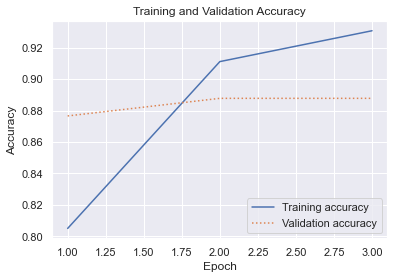

In [22]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [23]:
cleaned_text = remove_stop_words('Excellent food and fantastic service!')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.9431442

In [24]:
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.29550418